In [1]:
# Algebra and data manipulation
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline

# Data access and my own libraries
import glob, os, sys
sys.path.append(os.path.abspath('./libraries/')) 
import analysis_library as lib


# get SGD data (Park et. al TSS and PAS)
sgd = lib.SGD()  
roma = lib.roma

### Remove overlapping genes 
Only those genes were considered which had no overlap in with other genes in the TSS - 50 bp to TSS + 50% of gene length interval, which results in a list of 4808 genes

In [2]:
# Keep the original SGD
sgd_orig = sgd.copy()

# Find overlapping genes in park's data
loci=[]
for i in range(len(sgd)-10):
    for j in range(1,10):
        if sgd.ix[i,'max'] >= sgd.ix[i+j,'min_cassette'] and sgd.ix[i,'chromosome'] == sgd.ix[i+j,'chromosome']: 
            loci.append(sgd.iloc[i+j].name)     
        if sgd.ix[i,'max_cassette'] >= sgd.ix[i+j,'min'] and sgd.ix[i,'chromosome'] == sgd.ix[i+j,'chromosome']: 
            loci.append(sgd.iloc[i].name)

for i in set(loci):
    sgd.drop(i, axis=0, inplace=True)

sgd.count()

chromosome      4807
tss             4807
tes             4807
strand          4807
tss-50          4807
half            4807
min_cassette    4807
max_cassette    4807
min             4807
max             4807
dtype: int64

In [3]:
# Sanity check of the dataset filtering
sgd_orig.count()
overlap_index = set(sgd_orig.index) - set(sgd.index)
overlap_sgd = sgd_orig[sgd_orig.index.isin(overlap_index)]

### Load wiggle objects of sequenced gcn4 Pol_II and Mediator data
 - For now using _TSS - 100bp_ for the gcn4_PolII data and _500-600_ or _1000-600_ for the ChEC data. These onjects have been already created and after applying the meta_genomic function, they are stored into csv tables that are loaded here
 - <font color=red>I start by loading gcn4 and Pol_II data. Later Mediator</font> 
 - Later I could incorporate data from H3 seq @ https://www.ncbi.nlm.nih.gov/sra/?term=SRP034921 samples 12 and 13?
I downloaded these SRRs in ../aerijman/compare/

In [4]:
'''
List all wigs (already joined... Not all dulicates) and convert wig to wiggle 
objects and run meta_genomics and log
'''

Gcn4_ChEC = set([i for i in glob.glob('./data/SG_gcn4/*')])
PolII = set([i for i in glob.glob('./data/meta_genomics/*')])

for i in Gcn4_ChEC:
    name = i[15:-4]
    print name
    vars()[name] = pd.read_csv(i)
    vars()[name].set_index(vars()[name].columns[0], inplace=True)
    vars()[name].index.rename('position', inplace=True)
    

for i in PolII:
    name = i[21:-4]   
    print name
    vars()[name] = pd.read_csv(i)
    vars()[name].set_index(vars()[name].columns[0], inplace=True)
    vars()[name].index.rename('position', inplace=True)

# lastly one ChIP data
name = 'AE4_ATGTCA'
vars()[name] = pd.read_csv('./data/AE_ChIP/AE4_ATGTCA_Sc__meta_genomic.csv')
vars()[name].set_index(vars()[name].columns[0], inplace=True)
vars()[name].index.rename('position', inplace=True)

s64_G4MNmSM_2_100_ends__meta_genomic
SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic
del_gcn4_DMSO__meta_genomic
del_gcn4_SM__meta_genomic
WT_Gcn4_SM__meta_genomic
WT_Gcn4_DMSO__meta_genomic


### I compare ChIP-seq and ChEC-seq

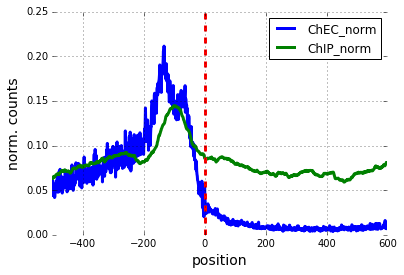

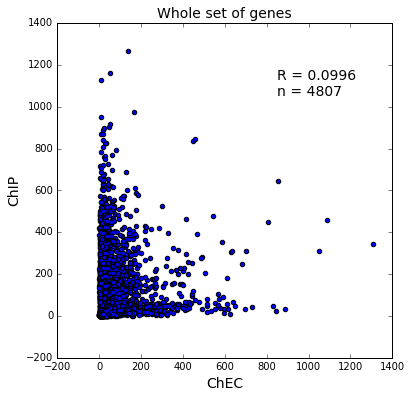

In [5]:
ChEC_norm = SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.sum(axis=1)/SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.shape[1]
ChIP_norm = AE4_ATGTCA.sum(axis=1) / AE4_ATGTCA.shape[1]

ChIP_ChEC_gcn4 = pd.concat([ChEC_norm, ChIP_norm], axis=1)
ChIP_ChEC_gcn4.columns = ['ChEC_norm', 'ChIP_norm']

# Plot of meta-analysis of ChEC and ChIP
ChIP_ChEC_gcn4.iloc[1:].plot(lw=3)
plt.plot([0,0],[0,0.3], lw=3, ls="--")
plt.ylim(0,0.25)
plt.box(on=None)
plt.grid()
plt.xlabel('position', fontsize=14)
plt.ylabel('norm. counts', fontsize=14)
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))


# Plot (scatter) correlation between ChEC and ChIP
a = pd.DataFrame(SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.sum(axis=0))
a.columns = ['ChEC']
b = pd.DataFrame(AE4_ATGTCA.sum(axis=0))
b.columns=['ChIP']
c = pd.concat([a, b], axis=1)

c.plot.scatter(x='ChEC', y='ChIP', figsize=(6,6))
plt.title('Whole set of genes', fontsize=14);
plt.xlabel('ChEC', fontsize=14)
plt.ylabel('ChIP', fontsize=14)
txt = 'R = ' + str(c.corr().values[1][0].round(4)) + '\nn = ' + str(c.shape[0])
plt.text(850,1050,txt, fontsize=14)

### <font color=green>Interesting...</font> Their meta analysis perfectly match but the correlation is a disaster... Let's see which are the genes that DO correlate.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


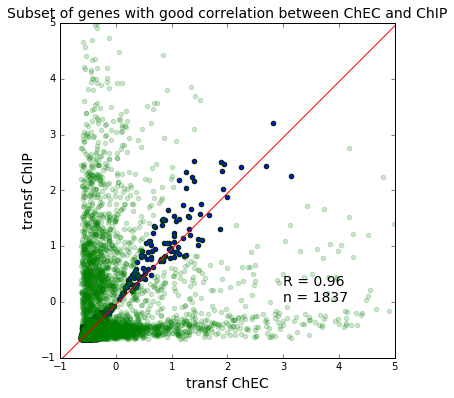

In [6]:
mE, mI = c.ChEC.mean(), c.ChIP.mean()
sE, sI = c.ChEC.std(), c.ChIP.std()
c['zChEC'] = c['ChEC'].apply(lambda x: (x - mE) / sE)
c['zChIP'] = (c['ChIP'] - mI) / sI

#drop NaNs
c.dropna(inplace=True)

# subset to work with towards defining the points that show correlation
c_box = c[['zChEC','zChIP']]

# add 0.01 to all points to avoid dealing with zeroes
c_box = c_box.apply(lambda x: x+0.001)

# divide them to see which points correlate
c_box['zcorr'] = c['zChEC'] / c['zChIP']

# Searching the data points that show best correlation
c_fit = c_box[(c_box['zcorr']<1.5) & (c_box['zcorr']>0.5)]

# plot a scatter plot with best fitting
c_fit.plot.scatter(x='zChEC', y='zChIP', figsize=(6,6));
# add all points with some alpha and green color
plt.scatter(x=c_box.zChEC.values, y=c_box.zChIP.values, color='green', alpha=0.2)


plt.xlabel('transf ChEC', fontsize=14)
plt.ylabel('transf ChIP', fontsize=14)
plt.title('Subset of genes with good correlation between ChEC and ChIP', fontsize=14);
#plt.box(on=None);
m,b = np.polyfit(c_fit.zChEC.values, c_fit.zChIP.values,1);
x=[-1,5]
plt.plot(x, m*x+b, color='red');
plt.xlim(-1,5);
plt.ylim(-1,5);
texto = 'R = ' + str(c_fit[['zChEC','zChIP']].corr().values[0][1].round(3)) \
        + '\nn = ' + str(c_fit.shape[0])
plt.text(3,0,texto, fontsize=14);

### So I keep a set of genes that should be responsible for the good match of the plot <font color=green>_count=f(position)_</font>

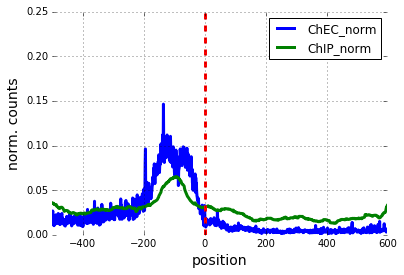

In [7]:
ChEC_ChIP_good_R = set(c_fit.index)

#just to simplify my life I rename these df
a = SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.copy()
a = a.loc[:, a.columns.isin(ChEC_ChIP_good_R)]
b = AE4_ATGTCA.copy()
b = AE4_ATGTCA.loc[:,AE4_ATGTCA.columns.isin(ChEC_ChIP_good_R)]

ChEC_norm = a.sum(axis=1)/a.shape[1]
ChIP_norm = b.sum(axis=1) / b.shape[1]

ChIP_ChEC_gcn4 = pd.concat([ChEC_norm, ChIP_norm], axis=1)
ChIP_ChEC_gcn4.columns = ['ChEC_norm', 'ChIP_norm']

# Plot of meta-analysis of ChEC and ChIP
ChIP_ChEC_gcn4.iloc[1:].plot(lw=3)
plt.plot([0,0],[0,0.3], lw=3, ls="--")
plt.ylim(0,0.25)
plt.box(on=None)
plt.grid()
plt.xlabel('position', fontsize=14)
plt.ylabel('norm. counts', fontsize=14)
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))'''

It turns out that the lack of correlation comes from beyond the TSSs?

## Analyze ChEC signal @telomers --> This is our noise or background ?

In [ ]:
# Abrir los wig y ver quantity and quality (peaks or not?) de senal en telomeros
#http://www.yeastgenome.org/contig/Chromosome_I/overview
#http://www.yeastgenome.org/contig/Chromosome_II/overview
#etc. Ver que los telomeros no son tan largos como dice ahi...

# Otra forma es verificar que cada senal sea en efecto un pico y no random signal.

#ChEC_telomer_test = lib.wiggle('./')

### Check if the signal comes from a peak or its just noisy reads... And it looks that >25% quantiles is a fair limit between signal and noise.

count    4807.000000
mean       42.755183
std        16.018385
min         0.846510
25%        32.590635
50%        40.632480
75%        50.790600
max       376.696949
dtype: float64

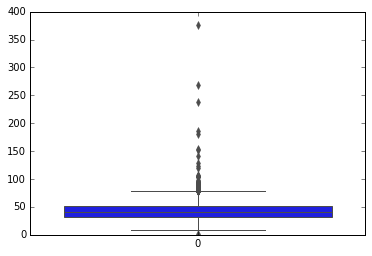

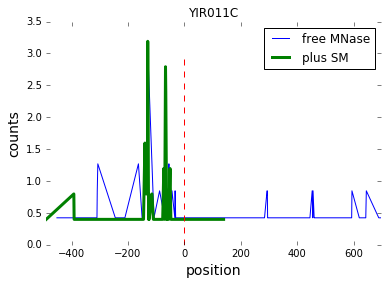

In [8]:
# Load the Free MNase wig into wiggle object
Free_MN = pd.read_csv('./data/Mediator/FreeMNase_5m__meta_genomic.csv')
Free_MN.set_index(Free_MN.columns[0], inplace=True)
Free_MN.index.rename('position', inplace=True)

# Let's start by observing distribution and characteristics of Free MNase.
sns.boxplot(data=Free_MN.sum(axis=0))
display(Free_MN.sum(axis=0).describe())

# Here I can spot some genes with weird ammounts of signal in the Free MNase
#display(Free_MN.sum(axis=0))#.sort_values())

# So then I can plot signal form Free MNase together with signal from Gcn4 for the same gene
a = Free_MN.sum(axis=0)
plt.figure()
Free_MN['YIR011C'].dropna().plot(label='free MNase')
SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic['YIR011C'].dropna().plot(label='plus SM', lw=3)
plt.box(on=None)
plt.xlabel('position', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.plot([0,0],[0,3], ls="--")
plt.legend()
plt.title('YIR011C')

### May be I should devide every ChEC signal to the Free MNase

,>1.1,<0.9,~1
plus/no SM,3943,855,9
no SM,4558,158,91
plus SM,4542,145,120
raw signal (plus/no SM),4435,369,3


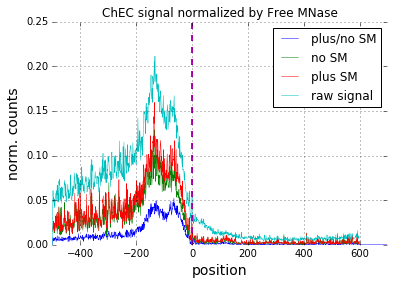

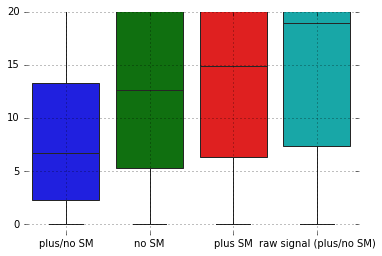

In [10]:
# Normalize gcn4 signal by free MNase
gcn4_ChEC_p = SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic / Free_MN
gcn4_ChEC_m = s64_G4MNmSM_2_100_ends__meta_genomic / Free_MN

# Compute the +SM / -SM 
gcn4_ChEC_pm = gcn4_ChEC_p / gcn4_ChEC_m
gcn4_ChEC_pm.fillna(0, inplace=True)
 
# Compute the "per gene" counts
a = gcn4_ChEC_pm.sum(axis=1) / gcn4_ChEC_pm.shape[1]
b = gcn4_ChEC_m.sum(axis=1) / gcn4_ChEC_m.shape[1]
c = gcn4_ChEC_p.sum(axis=1) / gcn4_ChEC_p.shape[1]

# Incorporate the raw signal "per gene"
d = SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.sum(axis=1)/SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.shape[1]
d.fillna(0, inplace=True)

# COncatenate all data towards a plot
e = pd.concat([a,b,c, d], axis=1)
e.columns = ['plus/no SM', 'no SM', 'plus SM', 'raw signal']

# Finally plot it
e.plot(lw=0.5)
plt.box(on=None)
plt.grid()
plt.xlabel('position', fontsize=14)
plt.ylabel('norm. counts', fontsize=14)
plt.title('ChEC signal normalized by Free MNase')
plt.plot([0,0],[0,0.25], lw=2, ls="--")

# concatenate the dfs on axis 0 to compare their statistical parameters
a = gcn4_ChEC_pm.sum(axis=0) 
b = gcn4_ChEC_m.sum(axis=0) 
c = gcn4_ChEC_p.sum(axis=0)
d = SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic / s64_G4MNmSM_2_100_ends__meta_genomic
d = d.sum(axis=0)

e = pd.concat([a,b,c,d], axis=1)
e.columns = ['plus/no SM', 'no SM', 'plus SM', 'raw signal (plus/no SM)']
e.fillna(0, inplace=True)

'''from scipy.stats import zscore
f = e.apply(zscore)
'''

# Check distribution of new data compared to original raw data
plt.figure()
sns.boxplot(data=e)
plt.box(on=None)
plt.grid()
plt.ylim(-1,20)

a1, a2 = pd.DataFrame(e[e>=1.1].count()), pd.DataFrame(e[e<=0.9].count())
a3 = pd.DataFrame(e[(e>0.9)&(e<1.1)].count())
a4 = pd.concat([a1,a2,a3], axis=1)
a4.columns = ['>1.1', '<0.9', '~1']
display(a4)
#plt.title('norm. distributions')

***
### What is the correlation between gcn4 data and Pol-II ChIP

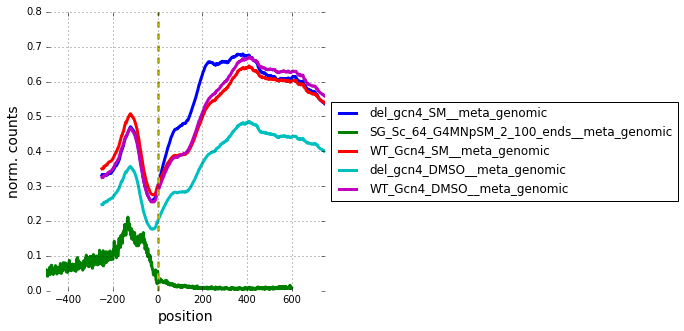

In [11]:
plt.figure(figsize=(5,5))

lista2 = ['del_gcn4_SM__meta_genomic','SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic','WT_Gcn4_SM__meta_genomic',\
          'del_gcn4_DMSO__meta_genomic','WT_Gcn4_DMSO__meta_genomic']

for name in lista2:
    df = vars()[name].iloc[1:]/vars()[name].iloc[1:].shape[1] 
    df.sum(axis=1).plot(label=name, lw=3)

plt.plot([0,0],[0,0.8], lw=3, ls="--")
plt.ylim(0,0.8)
plt.box(on=None)
plt.grid()
plt.xlabel('position', fontsize=14)
plt.ylabel('norm. counts', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('./PolII_ChIP_vs_ChEC-seq')

There are apparently two major differences with del gcn4. The most visible is that __ALL signal goes down__ upon addition of SM, even the minimum value @~-100. The other is that __the slope of the increase changes__ downstream of TSS upon addition of SM. Follolwing a plot to make clear the difference in the slope.

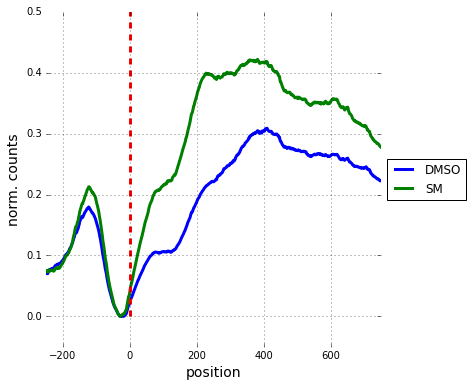

In [13]:
# Here I bring both DMSO and SM to zero so I can compate their slopes 
a = del_gcn4_DMSO__meta_genomic.iloc[1:].sum(axis=1) / del_gcn4_DMSO__meta_genomic.shape[1]
b = del_gcn4_SM__meta_genomic.iloc[1:].sum(axis=1) / del_gcn4_SM__meta_genomic.shape[1]
ma, mb = a.min(),b.min()
a, b = a-ma, b-mb

# plot it
plt.figure(figsize=(6,6))
a.plot(label='DMSO', lw=3)
b.plot(label='SM', lw=3)
plt.plot([0,0],[0,0.8], lw=3, ls="--")
plt.ylim(-0.05,0.5)
plt.box(on=None)
plt.grid()
plt.xlabel('position', fontsize=14)
plt.ylabel('norm. counts', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Let's make some space in the ram
del a,b

### Some conclusions form the previous plot
<font size=3>
 - I should align all courves to their same minimum --> make it zero. --> This will be done genewise
 - Then normalize Pol-II SM/DMSO for WT and del.
 - Lastly divide WT/del to correlate to gcn4
 </font>
* See What genes are in the extremes. 
    * Start with < 0 >
    * Then also try with strict outlyiers 
    

In [ ]:
# Will work with these files here
P2_gcn4_lista = ['WT_Gcn4_SM__meta_genomic', 'del_gcn4_SM__meta_genomic', \
                 'del_gcn4_DMSO__meta_genomic', 'WT_Gcn4_DMSO__meta_genomic']

# and will merge them into this df
P2_gcn4 = pd.DataFrame([])

'''
First check position-wise what are the std and plot it to see if INDEED, 
at the minimum position there is notmuch of a change
'''

def get_errors(df, vals, stdv):
    ind = df.index.values
    v = df[vals].values
    s = df[stdv].values
    m = []
    
    for i in range(0, len(v), 200):
        plt.plot([ind[i],ind[i]],[v[i]-s[i],v[i]+s[i]], lw=3)
         
plt.figure()
get_errors(tmp.iloc[1:], 'suma', 'stdv')
#WT_Gcn4_SM__meta_genomic.plot()



'''for name in P2_gcn4_lista:
    tmp = vars()[name].copy()
    tmp['suma'] = tmp.iloc[1:].sum(axis=1)/1000 
    tmp['stdv'] = tmp.iloc[1:].std(axis=1)     
'''
plt.legend()    
'''    
    P2_gcn4 = pd.concat([P2_gcn4,df], axis=1)

# Feature engineering
P2_gcn4['WT_SM/DMSO'] = P2_gcn4.WT_Gcn4_SM / P2_gcn4.WT_Gcn4_DMSO
P2_gcn4['del_SM/DMSO'] = P2_gcn4.del_gcn4_SM / P2_gcn4.del_gcn4_DMSO
P2_gcn4['WT/del'] = P2_gcn4['WT_SM/DMSO'] / P2_gcn4['del_SM/DMSO']
P2_gcn4['log2-WTn/deln'] = np.log2(P2_gcn4['WT_SM/DMSO'] / P2_gcn4['del_SM/DMSO'])
mn, sd = P2_gcn4['log2-WTn/deln'].mean(), P2_gcn4['log2-WTn/deln'].std() 

P2_gcn4['zscore_2log'] = (P2_gcn4['log2-WTn/deln']-mn) / sd
'''
# cleaning NaNs
#P2_gcn4.fillna(10, inplace=True)

#P2_gcn4[['WT_SM/DMSO','del_SM/DMSO','log2-WTn/deln']].hist(bins=100)
#plt.figure(figsize=(5,5))
#sns.distplot(P2_gcn4['log2-WTn/deln'], hist=False, rug=True, kde_kws={"linewidth":2});
'''plt.figure(figsize=(5,5))
sns.boxplot(data=P2_gcn4[['WT_SM/DMSO','del_SM/DMSO','WT/del']]) #,'log2-WTn/deln']]) #,'zscore_2log']])
#plt.ylim(-2.5,4)
plt.box(on=None)
plt.grid() 
#plt.xlim(0,4000)'''

***

### Pol_II data df  --> <font color=red>__P2_gcn4_positives__</font>

In [ ]:
P2_gcn4_positives = P2_gcn4.loc[P2_gcn4['log2-WTn/deln']>0,'log2-WTn/deln']
P2_gcn4_negatives = P2_gcn4.loc[P2_gcn4['log2-WTn/deln']<0,'log2-WTn/deln']

### Gcn4_ChEC df --> <font color=red>__ChEC_gcn4__</font>

In [ ]:
gcn4_ChEC_lista = ['s64_G4MNmSM_2_100_ends__meta_genomic', 'SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic']
ChEC_gcn4 = pd.DataFrame([])

for name in gcn4_ChEC_lista:
    vars()[name].set_index(vars()[name].columns[0], inplace=True)
    vars()[name].index.rename('position', inplace=True)
    vars()[name].fillna(0, inplace=True)
    df = pd.DataFrame(vars()[name].iloc[1:500].sum(axis=0)) 
    df.columns = [name[:-14]]
    
    ChEC_gcn4 = pd.concat([ChEC_gcn4,df], axis=1)

ChEC_gcn4.columns = ['DMSO','SM']
ChEC_gcn4['SM/DMSO'] = ChEC_gcn4.DMSO / ChEC_gcn4.SM
ChEC_gcn4['log2_SM/DMSO'] = np.log2(ChEC_gcn4['SM/DMSO'])

### Categorical casting of genes on presence or absence in SM or even DMSO Venn diagrams

which genes were pesent in DMSO? --> See below: I will use the 25%-most genes for both presence or absence

In [ ]:
ChEC_gcn4_B = ChEC_gcn4.copy()
ChEC_gcn4_B.dropna(inplace=True)
ChEC_gcn4.replace(np.inf,10, inplace=True)
ChEC_gcn4.replace(-np.inf,-10, inplace=True)

# to fill from describe() values different categories
ChEC_gcn4['present_in_DMSO'] = ChEC_gcn4.DMSO > 0
ChEC_gcn4['goes_up_with_SM'] = ChEC_gcn4['SM/DMSO'] > 1.1699
ChEC_gcn4['goes_down_with_SM'] = ChEC_gcn4['SM/DMSO'] < 0.686
ChEC_gcn4.describe()

In [ ]:
import venn

# Cuales ChEC estan presentes con DMSO y cuales en SM
g0 = set(sgd.index)
g1 = set(ChEC_gcn4.loc[ChEC_gcn4['present_in_DMSO'], 'present_in_DMSO'].index)
g2 = set(ChEC_gcn4.loc[ChEC_gcn4['goes_up_with_SM'], 'goes_up_with_SM'].index)
g3 = set(ChEC_gcn4.loc[ChEC_gcn4['goes_down_with_SM'],'goes_down_with_SM'].index)

labels = venn.get_labels([g0, g1, g2, g3], fill=['number'])
fig, ax = venn.venn4(labels, names=['All genes', 'gcn4 ChEC signal in DMSO', 'gcn4 ChEC signal goes up in SM',\
                                    'gcn4 ChEC signal goes down in SM'])
fig.show()


#### <font color=blue>I will try to correlate the <span style="background-color: #33E6FF">total signal of ChEC/gene</span> to signal in <span style="background-color: #33E6FF">-200-(-10), 0-100, 100-200, 200-400 and total from PolII-ChIP.</font> <font color=blue>Here I also take Rhee's data to group genes</font>  

In [ ]:
totals = pd.DataFrame([])

# 250 es iloc[0]!!
for i in [[0,240],[250,350],[350,450],[450,650]]:
    name = 'P2_del_gcn4' + str([j-250 for j in i])
    tmp = pd.DataFrame(del_gcn4_SM__meta_genomic.iloc[i[0]:i[1]].sum(axis=0))
    tmp.columns = [name]
    totals = pd.concat([totals, tmp], axis=1)

ChEC_gcn4 = pd.DataFrame(SG_Sc_64_G4MNpSM_2_100_ends__meta_genomic.sum(axis=0))
ChEC_gcn4.columns = ['ChEC_gcn4']
P2_del_gcn4_total = pd.DataFrame(del_gcn4_SM__meta_genomic.sum(axis=0))
P2_del_gcn4_total.columns = ['P2_del_gcn4_total']
P2_gcn4_total = pd.DataFrame(WT_Gcn4_SM__meta_genomic.sum(axis=0))
P2_gcn4_total.columns = ['P2_gcn4_total']

totals = pd.concat([totals,ChEC_gcn4, P2_del_gcn4_total, P2_gcn4_total], axis=1)


# Include Rhee's data on tata and taf1
'''Rhee = pd.read_excel('../../Downloads/nature10799-s2/Rhee_SuppData1_revised.xls')
Rhee = Rhee[['gene_id','gene_class_1','gene_class_2','mismatch']]
Rhee.set_index('gene_id', inplace=True)
Rhee['mismatch'] = Rhee.mismatch.str[:1]'''

#totals2 = pd.concat([totals, Rhee], axis=1)
#print totals2
#Rhee = Rhee[Rhee.index.duplicated(keep=False)==False]

# Adicionar Rhee a totals
totals2 = pd.concat([totals,Rhee], axis=1, join='inner')


In [ ]:
plt.figure(figsize=(20,5));
sns.boxplot(data=totals)
plt.ylim(0,500);

# <font color=red> CHECK THAT NUCLEOSOME IS THERE!!! CHECK SINGLE GENES WHERE THERE IS NO GENE 400 UPSTREAM!!!
</font> Looking from right to left (down to upstream), if the signal goes to zero (+noise) and stays there, that would mean that the transcription factors bind DNA towards the TSS prior to do their job. BUT, the small peak to the left of the valley (or minimum) points to some binding there. This signal can't belong to the downstream signal. And if there is some binding ~150bp before the TSS, why does it disappears to suddenly raise on the right again for our main signal?
Could it be that the factors are in line forming the mega-complexes about -150 from TSS BUT there is -a nucleosome?- downstream that do not let the factors go ahead?



In [ ]:

#df['avg'] = df.sum(axis=1)/len(df)
#m = df.avg.values
#y = df.index
#plt.fill_between(y,m, alpha=0.3, label='joya')
#plt.xlim(-250,750)
#plt.legend()

In [ ]:
'''
Trying bringing the minima to zero...
'''

totals1 = totals - totals.min()

plt.figure();
tmp = totals1[['Taf7_YPD_DMSO__meta_genomic', 'Taf7_YPD_3IAA__meta_genomic', 'Spt20_deg_GC_3IAA__meta_genomic',\
             'Spt20_deg_GC_DMSO__meta_genomic','Spt20_deg_YPD_3IAA__meta_genomic', \
              '143_Spt20_deg_YPD_DMSO_B_Sc__meta_genomic']]
tmp.plot(figsize=(15,15), linewidth=5, fontsize=14)
plt.plot([0,0],[0,1.2],ls='--', lw=3, color='k')
plt.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.xlabel('position (relative to TSS)',fontsize=14)
plt.ylabel('norm counts',fontsize=14)
plt.savefig('./Spt20_reads_distribution_zeroed.jpg')

#### Boxplots

In [ ]:
logs = sgd.chromosome
for i in glob.glob('./*log*csv'):
    name = i[2:-4]
    vars()[name] = pd.read_csv(i)
    vars()[name].set_index('locus', inplace=True)
    vars()[name].columns = [name]
    logs = pd.concat([logs,vars()[name]], axis=1, join='inner')

'''
Include Pugh's data about Taf1 and TATA
'''

pugh = pd.read_excel('../../Rhee_SuppData1_revised.xls')
pugh = pugh[['gene_id', 'gene_class_1','gene_class_2']]
pugh.set_index('gene_id', inplace=True)
pugh.dropna(inplace=True)
#print set(pugh.gene_class_1)
#print set(pugh.gene_class_2)
pugh.columns = ['TATA','Taf1']


logs = pd.concat([logs,pugh], axis=1, join='inner')
logs.drop('chromosome', axis=1, inplace=True)

logs['Taf7'] = np.log2(logs['Taf7_YPD_3IAA__log']/logs['Taf7_YPD_DMSO__log'])
logs['Spt20_GC'] = np.log2(logs['Spt20_deg_GC_3IAA__log']/logs['Spt20_deg_GC_DMSO__log'])
logs['Spt20_YPD'] = np.log2(logs['Spt20_deg_YPD_3IAA__log']/logs['143_Spt20_deg_YPD_DMSO_B_Sc__log'])
logs['Spt3_YPD'] = np.log2(logs['Spt3_deg_YPD_3IAA__log']/logs['Spt3_deg_YPD_DMSO__log'])

logs2 = logs[['Taf7', 'Spt20_GC', 'Spt20_YPD', 'Spt3_YPD', 'Taf1', 'TATA']]

logs2.to_csv('logs2.csv')

logs2.boxplot(figsize=(20,20), showfliers=False, rot=90)
logs2.boxplot(by='Taf1', showfliers=False, figsize=(10,10));
logs2.boxplot(by='TATA', showfliers=False, figsize=(10,10));

In [ ]:
#ypd_3iaa = Spt20_deg_YPD_3IAA.meta_genomic(sgd_slice=sgd)
#gc_3iaa = Spt20_deg_GC_3IAA.meta_genomic(sgd_slice=sgd)
#gc_dmso = Spt20_deg_GC_DMSO.meta_genomic(sgd_slice=sgd)

#ypd_3iaa['ypd_3iaa'] = ypd_3iaa.iloc[1:].sum(axis=1) / ypd_3iaa.shape[1]
#gc_3iaa['gc_3iaa'] = gc_3iaa.iloc[1:].sum(axis=1) / gc_3iaa.shape[1]
#gc_dmso['gc_dmso'] = gc_dmso.iloc[1:].sum(axis=1) / gc_dmso.shape[1]

#gral = pd.concat([ypd_3iaa.ypd_3iaa, gc_3iaa.gc_3iaa, gc_dmso.gc_dmso], axis=1, join='inner')

#ypd_3iaa_log = Spt20_deg_YPD_3IAA.wig2log(sgd_slice=sgd)
#gc_3iaa_log = Spt20_deg_GC_3IAA.wig2log(sgd_slice=sgd)
#gc_dmso_log = Spt20_deg_GC_DMSO.wig2log(sgd_slice=sgd)
#ypd_3iaa_log.columns = ['ypd_3iaa_log']
#gc_3iaa_log.columns = ['gc_3iaa_log']
#gc_dmso_log.columns = ['gc_dmso_log']

#gral2 = pd.concat([ypd_3iaa_log, gc_3iaa_log, gc_dmso_log], axis=1, join='inner')

#gral2['gc_log2'] = np.log2(gral2.gc_3iaa_log/gral2.gc_dmso_log) 


gral2.boxplot()
plt.ylim(-1,100)

gral.plot(lw=4, fontsize=14, figsize=(10,10))

taf7_ypd_dmso.plot(lw=4, fontsize=14, figsize=(10,10))

plt.plot([0,0],[0,1.2], ls='--', lw=3, c='black')
plt.ylabel('normalized avg. counts', fontsize=14)
plt.ylim(0,1.2)
plt.savefig('no_diff_first_100bp_Spt20.jpg')

In [ ]:
#taf7_meta = vars()['compare/Taf7_YPD_DMSO'].meta_genomic(sgd_slice=sgd)
#taf7_ypd_dmso =  taf7_meta.iloc[1:].sum(axis=1) / taf7_meta.shape[1]
taf7_ypd_dmso.plot()

In [ ]:
for i in [Spt20_deg_GC_3IAA_metGen, Spt20_deg_YPD_3IAA_metGen, Spt20_deg_GC_DMSO_metGen]:
    i.set_index(i.columns[0], inplace=True)
    i['totals'] = i.sum(axis=1) / i.shape[1]

#WT_Taf1_metGen.set_index(WT_Taf1_metGen.columns[0], inplace=True)
#WT_Taf1_metGen['totals'] = WT_Taf1_metGen.sum(axis=1)
#WT_Taf1_metGen['totals'] = WT_Taf1_metGen.totals / WT_Taf1_metGen.shape[1]

### Plot tss-100bp distribution for all genes in filtered list

In [ ]:

# Plot them...
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.plot([0,0],[0,1], ls='--', lw=3, c='black')

for i in ['WT_Gcn4_DMSO_metGen', 'WT_Gcn4_SM_metGen', 'Spt20_deg_GC_3IAA_metGen', 'Spt20_deg_YPD_3IAA_metGen', 'Spt20_deg_GC_DMSO_metGen']:
    vars()[i].totals.plot(label=i, lw=4, fontsize=14)

#plt.fill_between(m84_dmso_IN.index.values, m84_dmso_IN.values/3, alpha=0.3, label='Input')
#plt.fill_between(m84_dmso_IP.index.values, m84_dmso_IP.values/3, alpha=0.3, label='Input2')

ax.legend(loc=2, fontsize=14)
#plt.ylim(0.2,1.5)
plt.xlim(-200,750)
plt.ylabel('normalized avg. counts', fontsize=14)
plt.xlabel(Spt20_deg_GC_3IAA_metGen.index.name, fontsize=14)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, which='both')

In [ ]:
n=0
for i in glob.glob('./wig/*Spt20*wig'):
    if n>=3:
        continue
    name = i[6:-4]
    vars()[name] = lib.wiggle(i)
    name2 = name + '_metaGen'
    vars()[name2] = vars()[name].meta_genomic(sgd)
    n+=1

In [ ]:
vars()['144_Spt20_deg_YPD_3IAA_B_Sc'].wig.head(5)

# from the manuscript:
<div class="alert alert-block alert-info">first, total normalized signal per bp in the interval TSS to TSS+100 bp was calculated for each gene in the +DMSO and +3-IAA datasets</div>

### I already prepared the csv files below. Don't have to run this again...

In [ ]:
list_A = [i for i in glob.glob('./wig/*_A_*.wig')]
list_B = [i for i in glob.glob('./wig/*_B_*.wig')]
list_all = [i for i in glob.glob('./wig/*.wig')]
diff = set(list_all) - set(list_A) -set(list_B)
for i in diff:
    name = i[6:-4]
    vars()[name] = lib.wiggle(i)
    name_log = name + "_log2"
    vars()[name_log] = vars()[name].wig2log()
    out_name = name + '.csv'
    vars()[name_log].to_csv(out_name)

file_solit = './wig/143_Spt20_deg_YPD_DMSO_B_Sc.wig'
name_solit = file_solit[6:-4]
vars()[name_solit] = lib.wiggle(file_solit)
name_log = name_solit + "_log2"
vars()[name_log] = vars()[name_solit].wig2log()
out_name = name_solit + '.csv'
vars()[name_log].to_csv(out_name)

## Will have to run this again!!

In [ ]:
lista=[]
for i in glob.glob('./*csv'):
    if i=='./lwarfield.csv' or i=='./lwarfield_v3.csv' or i=='./clusters.csv':
        continue
    
    name = i[2:-4]
    lista.append(name)
    vars()[name] = pd.read_csv(i)
    vars()[name].set_index('locus', inplace=True)
    vars()[name].columns = [name]
    print name

# from the manuscript:
<div class="alert alert-block alert-info">Then, a log ratio of +3-IAA to +DMSO was calculated as the net effect of depletion of different factors in the degron strains</div>
## <font color=red>It is log2 not log10...</font>

In [ ]:
Spt20_deg_YPD = pd.concat([vars()['143_Spt20_deg_YPD_DMSO_B_Sc'],Spt20_deg_YPD_3IAA], axis=1, join='inner')
Spt20_deg_YPD.columns = ['DMSO', '3IAA']
Spt20_deg_YPD['Spt20_deg_YPD_log2'] = np.log2(Spt20_deg_YPD['3IAA']/Spt20_deg_YPD['DMSO'])

Spt20_deg_GC = pd.concat([Spt20_deg_GC_DMSO, Spt20_deg_GC_3IAA], axis=1, join='inner')
Spt20_deg_GC.columns = ['DMSO', '3IAA']
Spt20_deg_GC['Spt20_deg_GC_log2'] = np.log2(Spt20_deg_GC['3IAA']/Spt20_deg_GC['DMSO'])

Spt3_deg_YPD = pd.concat([Spt3_deg_YPD_DMSO, Spt3_deg_YPD_3IAA], axis=1, join='inner')
Spt3_deg_YPD.columns = ['DMSO', '3IAA']
Spt3_deg_YPD['Spt3_deg_YPD_log2'] = np.log2(Spt3_deg_YPD['3IAA']/Spt3_deg_YPD['DMSO'])

WT_Gcn4 = pd.concat([WT_Gcn4_DMSO, WT_Gcn4_SM], axis=1, join='inner')
WT_Gcn4.columns = ['DMSO', 'SM']
WT_Gcn4['WT_Gcn4_log2'] = np.log2(WT_Gcn4['SM']/WT_Gcn4['DMSO'])

del_Gcn4 = pd.concat([del_gcn4_DMSO, del_gcn4_SM], axis=1, join='inner')
del_Gcn4.columns = ['DMSO','SM']
del_Gcn4['del_Gcn4_log2'] = np.log2(del_Gcn4['SM']/del_Gcn4['DMSO'])

gral = pd.concat([Spt20_deg_YPD['Spt20_deg_YPD_log2'], Spt20_deg_GC['Spt20_deg_GC_log2'], \
                 Spt3_deg_YPD['Spt3_deg_YPD_log2'], WT_Gcn4['WT_Gcn4_log2'], del_Gcn4['del_Gcn4_log2']], \
                 axis=1, join='inner')

# There were some -inf that must be taken off to downstream calculations
gral.drop(gral[gral[gral.columns[0]]==-np.inf].index[0], axis=0, inplace=True)
gral.dropna(inplace=True)

# Download Pugh's data and include Taf1 and TATA columns to each df
Taf1 and TATA data from:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3306527/

In [ ]:
pugh = pd.read_excel('../../Rhee_SuppData1_revised.xls')
pugh = pugh[['gene_id', 'gene_class_1','gene_class_2']]
pugh.set_index('gene_id', inplace=True)
pugh.dropna(inplace=True)
print set(pugh.gene_class_1)
print set(pugh.gene_class_2)
pugh.columns = ['TATA','Taf1']

### Merge dfs with pughs. Later, mix all log2s with pughs data 

In [ ]:
lista = ['Spt20_deg_YPD','Spt20_deg_GC','Spt3_deg_YPD','WT_Gcn4','del_Gcn4']
for i in lista:
    name = 'pugh_' + i
    vars()[name] = pd.concat([vars()[i], pugh], join='inner', axis=1)

In [ ]:
log2_pugh = pd.concat([Spt20_deg_YPD['Spt20_deg_YPD_log2'],Spt20_deg_GC['Spt20_deg_GC_log2'],\
                       Spt3_deg_YPD['Spt3_deg_YPD_log2'],WT_Gcn4['WT_Gcn4_log2'],\
                                    del_Gcn4['del_Gcn4_log2'], pugh], join='inner', axis=1)

In [ ]:
log2_pugh.boxplot(by='Taf1', figsize=(10,10));
plt.savefig('boxplots_Taf1.jpg')

In [ ]:
log2_pugh.boxplot(by='TATA', figsize=(10,10));
plt.ylim(-2,1.5)
plt.savefig('boxplots_TATA.jpg')

### <font color=red>Calculate z-scores... For normalizing the distribution? The distribution is already normal...</font>

In [ ]:
for i in gral.columns:
    name = i + 'z_score'
    m, s = np.mean(gral[i]), np.std(gral[i])
    gral[name] = (gral[i] - m) / s

'''wt_mean, taf7_mean = np.mean(wt_log2), np.mean(taf7_log2)
wt_std, taf7_std = wt_log2.std(), taf7_log2.std()

wt_zscores = (wt_log2-wt_mean) / wt_std
taf7_zscores = (taf7_log2-taf7_mean) / taf7_std

plt.figure()
wt_log2.hist(bins=100)
plt.xlim(-6,6);

plt.figure()
wt_zscores.hist(bins=100)
plt.xlim(-6,6);'''

In [ ]:
gral.hist(bins=50, figsize=(20,20));

### Combine dfs, export and check the correlation chart

## Clustering analysis, first set up dataset and import analytical libraries

In [ ]:
from sklearn.cluster import KMeans

# Convert DataFrame to matrix
mat = gral.ix[:,5:].as_matrix()

### Decide the optimal number of clusters (Elbow)

In [ ]:
'''from scipy.spatial.distance import cdist, pdist

k_range = range(1,50)
k_means_obj = [KMeans(n_clusters=k).fit(mat) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_obj]

k_euclid = [cdist(mat, cen, 'euclidean') for cen in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
sumaQuaDist = [sum(d**2) for d in dist]
tss = sum(pdist(mat)**2)/mat.shape[0]
bss = tss - sumaQuaDist'''

plt.plot(bss)
plt.ylabel('% variance')
plt.xlabel('# clusters')
plt.plot([5,5],[0,20000], lw=3, ls='--')
plt.xticks(np.arange(0, 50, 5));

### Distribute data through the k clusters decided above

In [ ]:
# Using sklearn
km = KMeans(n_clusters=5)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([gral.index,labels]).T

### Plot the results to see how Srinivas clusters fit to the new data

In [ ]:
results.columns = ['locus','group']
results.set_index('locus', inplace=True)
cluster = pd.concat([gral.ix[:,5:],results],axis=1,join='inner')
cluster.sort_values('group', inplace=True)
cluster = cluster*100
cluster = cluster.astype(int)

fig, ax = plt.subplots(1,1, figsize=(5,10))
ax.pcolor(cluster, cmap='Greens', label=cluster.columns);
ax.set_xticklabels(cluster.columns, rotation='vertical', fontsize=15, ha='left');

# check max and min values
print np.max(cluster.max()), np.min(cluster.min())

In [ ]:
for i in ['taf7_dmso', 'taf7_3iaa', 'wt_dmso', 'wt_3iaa']:
    vars()[i].columns = [i]
wt_taf7 = pd.concat([taf7_dmso, taf7_3iaa, wt_dmso, wt_3iaa], join='inner', axis=1)
#wt_taf7.to_csv('./wt_taf7__dmso_3iaa.csv')
wt_taf7.dropna(inplace=True)
wt_taf7.corr()

In [ ]:
log2s = pd.concat([wt_log2, taf7_log2], join='inner', axis=1)
log2s.columns = ['wt','taf7']
log2s.boxplot();

#### Taf1 data from:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3306527/

http://science.sciencemag.org/content/288/5469/1244
http://science.sciencemag.org/content/288/5469/1242



In [ ]:
pugh = pd.read_excel('../Rhee_SuppData1_revised.xls')
pugh = pugh[['gene_id', 'gene_class_1','gene_class_2']]
pugh.set_index('gene_id', inplace=True)
pugh.dropna(inplace=True)
print set(pugh.gene_class_1)
print set(pugh.gene_class_2)

In [ ]:
complete = pd.concat([log2s, pugh], join='inner', axis=1)
#complete['taf1'] = pd.Categorical(complete.gene_class_2)
#complete['tata'] = pd.Categorical(complete.gene_class_1)

In [ ]:
#complete.drop(['taf1'], axis=1, inplace=True)
complete.columns = ['wt','taf7','tata','taf1']
complete.boxplot(by='taf1');
complete.boxplot(by='tata');

### <font color=red>What are the Control Pol II ChIP used by Srinivas?</font>

In [ ]:
df = pd.concat([log2s, wt_dmso], join='inner', axis=1)
df.dropna(inplace=True)
#log2s.dropna(inplace=True)
#plt.figure(figsize=(5,5))


plt.hexbin(df.wt_dmso, df.taf7, bins=300, cmap='hot_r');
#plt.ylim(-4,2)
plt.xlim(-2,500);
plt.title('log2 vs counts', fontsize=20);

'''plt.figure()
plt.hist2d(log2s.taf7,log2s.wt,bins=100)
plt.title('log2 for both', fontsize=20);'''